# **Laboratory work**

*made by Ostap Kostiuk and Yulian Zaiats*

#### **In this laboratory work we worked with such algorithms as *Prim's algorithm*, *Bellman-Ford's algorithm* and *DecisionTree*.**

#### **We tried to make our own implementations of every algorithm and compare them with built-in ones.**

#### **All of the implementations and results you can see below:**

In [31]:
# -m pip install networkx
# -m pip install matplotlib
# !pip install tqdm
# !pip install pandas
# !pip install numpy
# !pip install graphviz
# !pip install scikit-learn

In [47]:
import random
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby

from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance
from networkx.algorithms import floyd_warshall_predecessor_and_distance

import numpy.typing as npt

# **Task 1. Algorithm's analysis**

## Generating graph

In [33]:

# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

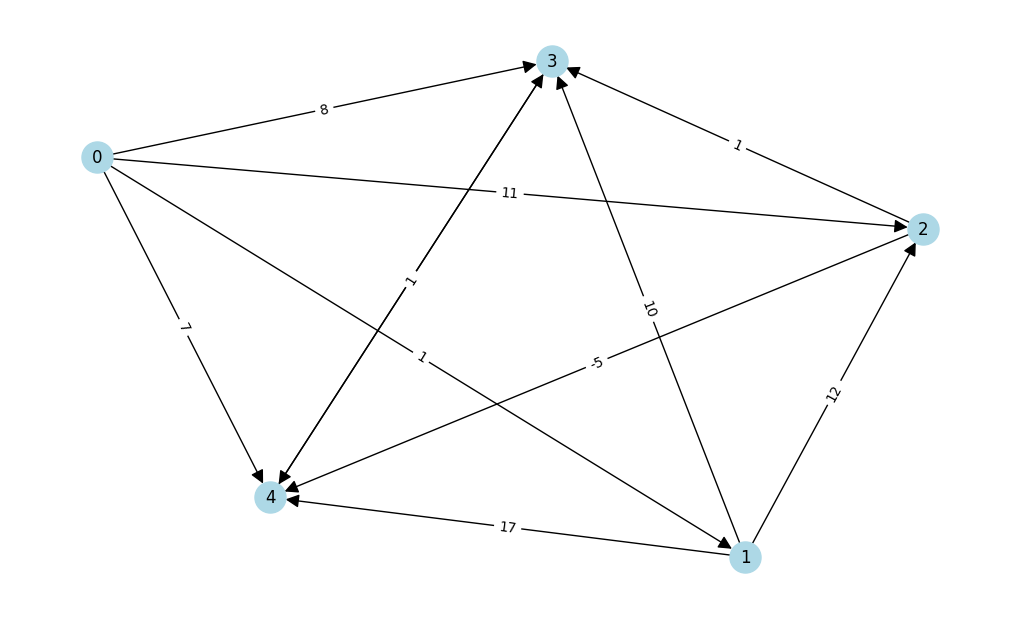

In [34]:
G = gnp_random_connected_graph(5, 5, True, True)

## Subtask 1.1

### **Prim's algorithm**

In [35]:
def prim(graph):
    '''
    computes prim's algorythm
    '''
    
    start = random.choice(list(graph.nodes))
    mst = nx.Graph()
    visited = {start}

    while len(visited) < len(graph.nodes):
        best_weight = float('inf')
        best_edge = None

        for node in visited:
            for neighbor, info in graph[node].items():
                weight = info['weight']
                if neighbor not in visited and weight < best_weight:
                    best_weight = weight
                    best_edge = (node, neighbor)
        
        if best_edge:
            mst.add_edge(best_edge[0], best_edge[1], weight=best_weight)
            visited.add(best_edge[1])

    return mst

### *Results:*

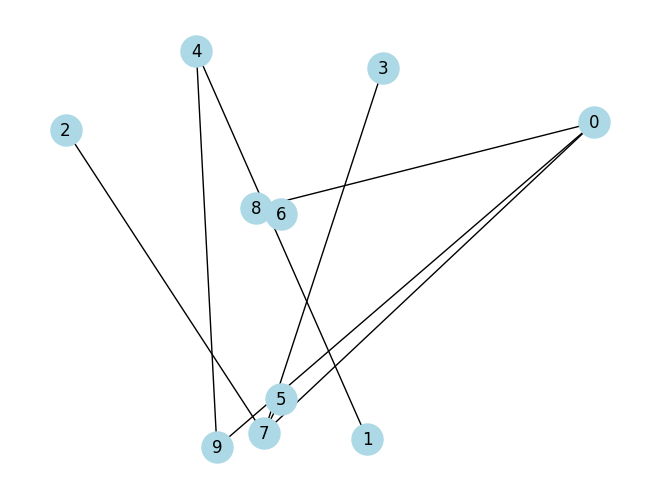

In [36]:
num_of_nodes = 10
completeness = 0.5
G = gnp_random_connected_graph(num_of_nodes, completeness, directed=False, draw=False)
mst = prim(G)
nx.draw(mst, node_color='lightblue', with_labels=True, node_size=500) 

### **Report on Prim's algorithm**

**Prim's algorithm** is an algorithm used to find the **Minimal Spanning Tree** (MST) of a *connected, indirected weighted graph.*

**Input:**
Connected undirected nx.Graph

**Output:**
MST of a graph (nx.Graph)

1. A random starting node is chosen, empty graph and visited set is created.

2. Loop continues until all nodes are in visited.

3. For each node we look for its neighbors.

4. For each neighbor we check if a neighbor is not in visited yet and if current edge weight is smaller than best_edge.

5. best_edge is added to MST and node is added to visited.

---

#### **Time complexity analysis**

Choosing random starting node: O(1)

Iterating through *O(V)*, where V is a number of vertices.

For each node, iterate over its neighbors *O(E)*.

So, the time complexity is *O(V*E)*

---

But, using **priority queue (min-heap)** we can optimize the complexity to *O(ElogV)*

Instead of iterating over all edges to find the minimum-weight edge, 
a min-heap allows to extract the minimum-weight edge in *O(log⁡V)O(logV)* time.


---

## Subtask 1.2

### **Bellman-Ford algorithm**

In [37]:
def bellman_ford(graph: dict, source_vertex: str) -> dict[int | None]:
    """
    Takes in a graph, which is the graph in format (starting_vertex, ending_vertex, weight)
    also takes in the number of vertices and the source vertex

    returns a dict of the shortest distances or None if negative is detected

    Example:
        >>> import networkx as nx
        >>> G = nx.DiGraph()
        >>> G.add_weighted_edges_from([\
                (1, 2, 6),\
                (1, 5, 7),\
                (2, 5, 8),\
                (5, 4, 9),\
                (4, 3, 7),\
                (3, 2, -2),\
                (2, 3, 5),\
                (2, 4, -4),\
                (5, 3, -3)\
            ])
        >>> result = bellman_ford(G, 1)
        >>> print(result)
        Distance to 1: 0
        Distance to 2: 2
        Distance to 3: 4
        Distance to 4: -2
        Distance to 5: 7
    """
    # Make starting dictionary
    distances_dict = {node: float('inf') for node in graph.nodes}
    distances_dict[source_vertex] = 0
    num_vertices = len(graph.nodes)

    # Do algortihm vertices_num -1 times
    for _ in range(num_vertices - 1):
        for u, v, weights in graph.edges(data=True):
            weight = weights['weight']
            if distances_dict[u] + weight < distances_dict[v]:
                distances_dict[v] = distances_dict[u] + weight

    # Check extra time for neg cycle
    for u, v, weights in graph.edges(data=True):
        weight = weights['weight']
        if distances_dict[u] + weight < distances_dict[v]:
            print("The graph contains a negaitve weight cycle")

    # Sort starting dict
    sorted_dict = dict(sorted(distances_dict.items(), key=lambda item: item[0]))

    # Return nice output
    output = ''
    for num, (key, val) in enumerate(sorted_dict.items()):
        if num == len(sorted_dict) - 1:
            output += f"Distance to {key}: {val}"
            break
        output += f"Distance to {key}: {val}\n"
    return output

if __name__ == "__main__":
    import doctest
    print(doctest.testmod())


TestResults(failed=0, attempted=5)


### *Results:*

The graph contains a negaitve weight cycle
The graph contains a negaitve weight cycle
The graph contains a negaitve weight cycle
The graph contains a negaitve weight cycle
Distance to 0: inf
Distance to 1: -39
Distance to 2: -34
Distance to 3: -33
Distance to 4: inf
Distance to 5: -35
Distance to 6: -39
Distance to 7: -36
Distance to 8: -35
Distance to 9: -36


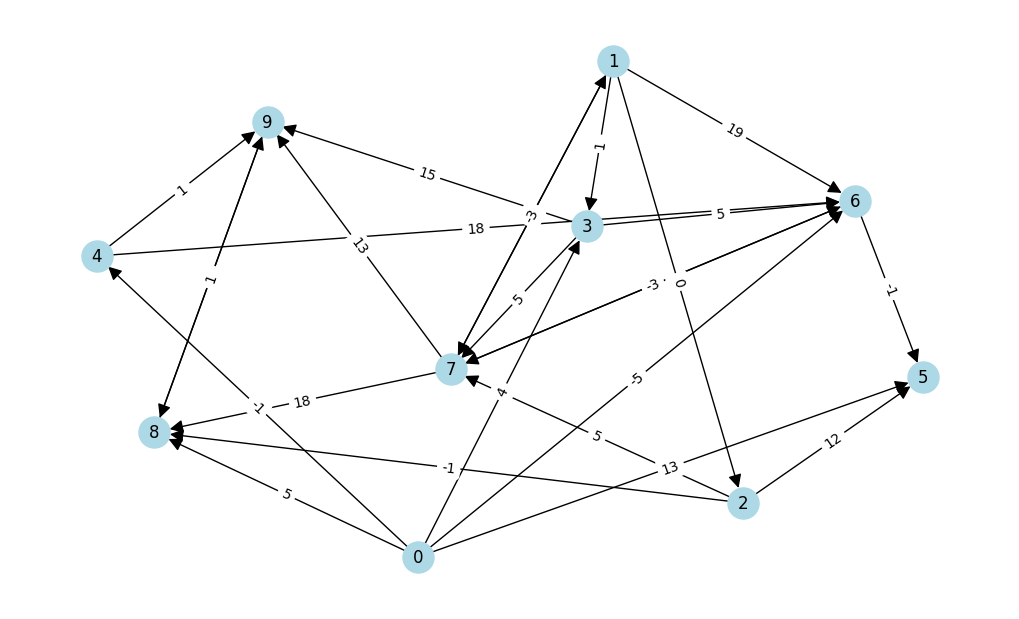

In [38]:
G = gnp_random_connected_graph(10, 0.5, True, True)
result = bellman_ford(G, 1)
print(result)

### **Report on Bellman-Ford algorythm**

**Bellman-Ford** algorithm is an algorithm used to compute the shortest paths from a source vertex to all other vertices in a directed weighted graph.


**Input:**
Directed weighted graph (e.g., nx.DiGraph) and a source vertex

**Output:**
A dictionary of the shortest distances from the source to each vertex (or a warning if a negative weight cycle is detected)

1. Set the distance to every vertex as infinity, except for the source vertex which is set to 0.

2. Repeat the following for |V| - 1 iterations (where |V| is the number of vertices):
For every edge (u, v) in the graph, update the distance to v if the path through u offers a shorter route.
In other words: if distance[u] + weight(u,v) < distance[v], then set distance[v] = distance[u] + weight(u,v).


3. After the relaxation steps, go through all the edges one more time.
If you can still relax any edge, then a negative weight cycle exists, and the algorithm warns you about it.

---

#### **Time complexity analysis**

Initialization: *O(V)*
Setting up your distances is a quick sprint through the vertices.

Edge Relaxation: *O(V * E)*
For each of the V - 1 iterations, you inspect all E edges.

Cycle Detection: *O(E)*
One more pass over the edges to double-check your work.

So, the overall time complexity is *O(V * E)*.

---

# **Time analysis and comparsions**

In [39]:
import time

def compare_two_funcs(func1, func2, graph, source_vertex, times_to_run):
    """
    Compares the average runtime of two functions.

    Parameters:
        func1, func2: The functions to test. They should accept (graph, source_vertex).
        graph: A NetworkX graph.
        source_vertex: The source vertex for the functions.
        times_to_run: How many times to run each function for averaging.
    """
    func1_time = 0
    func2_time = 0

    for _ in range(times_to_run):
        # test first function
        func1_start = time.time()
        func1(graph, source_vertex)
        func1_end = time.time()
        func1_time += (func1_end - func1_start)

        # test second function
        func2_start = time.time()
        func2(graph, source_vertex)
        func2_end = time.time()
        func2_time += (func2_end - func2_start)

    average_time_func1 = func1_time / times_to_run
    average_time_func2 = func2_time / times_to_run

    print(
        f"For a graph with {len(graph)} vertices and source vertex {source_vertex}, over {times_to_run} runs:\n"
        f" - Average time for func1: {average_time_func1:.6f} seconds.\n"
        f" - Average time for func2: {average_time_func2:.6f} seconds."
    )

### **Viaualization**


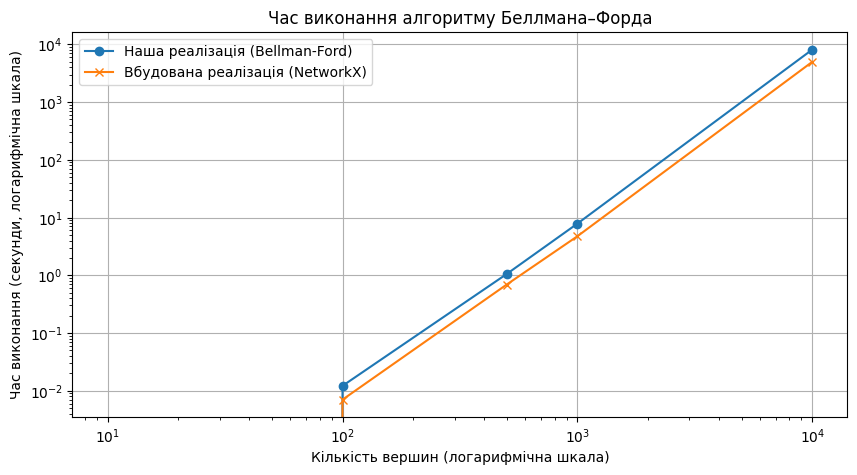

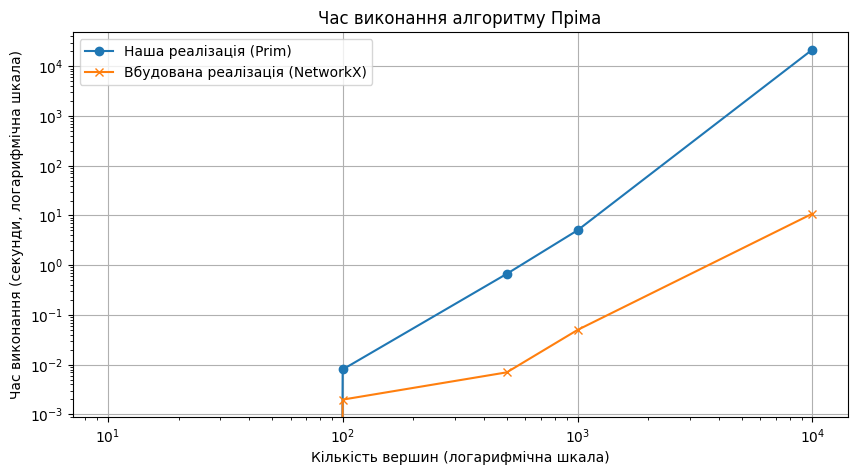

In [40]:
# bellman ford
vertices = [10, 100, 500, 1000, 10000]
custom_bf_times = [0.000000, 0.012162, 1.051642, 7.842443, 8095.991093]
builtin_bf_times = [0.000000, 0.007018, 0.690400, 4.738519, 4968.058102]

plt.figure(figsize=(10, 5))
plt.plot(vertices, custom_bf_times, marker='o', label='Наша реалізація (Bellman-Ford)')
plt.plot(vertices, builtin_bf_times, marker='x', label='Вбудована реалізація (NetworkX)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Кількість вершин (логарифмічна шкала)')
plt.ylabel('Час виконання (секунди, логарифмічна шкала)')
plt.title('Час виконання алгоритму Беллмана–Форда')
plt.legend()
plt.grid(True)
plt.show()

# prim
custom_prim_times = [0.000000, 0.008016, 0.671423, 5.034768, 21625.439981]
builtin_prim_times = [0.000000, 0.001984, 0.007016, 0.049932, 10.866875]

plt.figure(figsize=(10, 5))
plt.plot(vertices, custom_prim_times, marker='o', label='Наша реалізація (Prim)')
plt.plot(vertices, builtin_prim_times, marker='x', label='Вбудована реалізація (NetworkX)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Кількість вершин (логарифмічна шкала)')
plt.ylabel('Час виконання (секунди, логарифмічна шкала)')
plt.title('Час виконання алгоритму Пріма')
plt.legend()
plt.grid(True)
plt.show()


### **Report on time analysis**

The runtime of both algorithms was tested on graphs of different sizes, comparing our implementation with a built-in function.

#### **Bellman-Ford**

 - The built-in function (func2) consistently outperforms our implementation (func1).

 - As the graph size increases, the runtime grows rapidly, confirming Bellman-Ford’s O(V * E) complexity.

 - At 10,000 vertices, our implementation takes over 8,000 seconds, while the built-in function completes in 4,968 seconds.

#### **Prim's**

 - The built-in function (func2) is significantly faster, especially on large graphs.

 - Our implementation (func1) takes over 21,000 seconds for 10,000 vertices, while the built-in function runs in 10.86 seconds.

 - This confirms that the built-in function uses an optimized priority queue (min-heap), improving efficiency to O(E log V).

---

# **Decision Tree**

In [41]:
# importing all neccesary libraries
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from networkx.algorithms import tree
from graphviz import Digraph

### Setting things up

In [42]:
data = pd.read_csv('C:/Users/User/Downloads/drug200.csv')
encoding = {
    'Sex': {'F': 0, 'M': 1},
    'BP': {'LOW': 0, 'NORMAL': 1, 'HIGH': 2},
    'Cholesterol': {'NORMAL': 0, 'HIGH': 1},
    'Drug': {'drugA': 0, 'drugB': 1, 'drugC': 2, 'drugX': 3, 'drugY': 4}
}

data['Sex'] = data['Sex'].map(encoding['Sex'])
data['BP'] = data['BP'].map(encoding['BP'])
data['Cholesterol'] = data['Cholesterol'].map(encoding['Cholesterol'])
data['Drug'] = data['Drug'].map(encoding['Drug'])

X = data.drop('Drug', axis=1).values
y = data['Drug'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Main part

In [43]:
class Node: 
    def __init__(self, feature=None, threshold=None, left=None, right=None, label=None):
        self.feature = feature  
        self.threshold = threshold 
        self.left = left  
        self.right = right 
        self.label = label 

class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth  
        self.root = None 

    def gini(self, y):
        """computes gini impurity"""
        if len(y) == 0:
            return 0

        counter = {}
        for label in y:
            counter[label] = counter.get(label, 0) + 1

        impurity = 1
        for label in counter:

            probability = counter[label] / len(y)
            impurity -= probability ** 2

        return impurity

    def best_split(self, X, y):
        """finds best split based on features (X) and targets (y)"""
        best_gini = float('inf')
        best_split = None
        best_left_idx = None
        best_right_idx = None

        for feature in range(X.shape[1]):

            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:

                left_idx = np.where(X[:, feature] <= threshold)[0]
                right_idx = np.where(X[:, feature] > threshold)[0]

                if len(left_idx) == 0 or len(right_idx) == 0:
                    continue

                left_gini = self.gini(y[left_idx])
                right_gini = self.gini(y[right_idx])
                total_gini = (len(left_idx) * left_gini + len(right_idx) * right_gini) / len(y)

                if total_gini < best_gini:
                    best_gini = total_gini
                    best_split = (feature, threshold)
                    best_left_idx, best_right_idx = left_idx, right_idx

        return best_split, best_left_idx, best_right_idx

    def build_tree(self, X, y, depth=0):
        """recursively builds a tree"""

        if len(set(y)) == 1 or (self.max_depth is not None and depth >= self.max_depth):

            labels, counter = np.unique(y, return_counts=True)
            most_common_label = labels[np.argmax(counter)]
            return Node(label=most_common_label)

        split, left_idx, right_idx = self.best_split(X, y)

        if not split:
            labels, counter = np.unique(y, return_counts=True)
            most_common_label = labels[np.argmax(counter)]
            return Node(label=most_common_label)

        feature, threshold = split
        left_subtree = self.build_tree(X[left_idx], y[left_idx], depth + 1)
        right_subtree = self.build_tree(X[right_idx], y[right_idx], depth + 1)

        return Node(feature=feature, threshold=threshold, left=left_subtree, right=right_subtree)

    def fit(self, X, y):
        """tree learning"""
        self.root = self.build_tree(X, y)

    def predict(self, X):
        """predicts target for X"""
        predictions = []

        for row in X:
            node = self.root

            while node.label is None:
                if row[node.feature] <= node.threshold:
                    node = node.left
                else:
                    node = node.right

            predictions.append(node.label)

        return predictions
    
    def visualize(self, filename='decision_tree'):
        """Creates a Graphviz visualization of the decision tree"""
        dot = Digraph(comment='Decision Tree')
        
        def add_nodes_edges(node, parent_id=None, edge_label=''):
            nonlocal dot

            node_id = str(id(node))

            if node.label is not None:  # leaf node
                label = f'Class: {node.label}'
                dot.node(node_id, label, shape='box', style='filled', color='lightgreen')
            else:  # decision node
                label = f'Feature {node.feature}\n<= {node.threshold:.2f}'
                dot.node(node_id, label, shape='box', color='lightblue')

            if parent_id is not None:
                dot.edge(parent_id, node_id, label=edge_label)

            if node.left:
                add_nodes_edges(node.left, node_id, '≤ threshold')
            if node.right:
                add_nodes_edges(node.right, node_id, '> threshold')

        if self.root:
            add_nodes_edges(self.root)

        # render and display
        dot.render(filename, format='pdf', cleanup=True)
        return dot

### Initializing and training the decision tree

In [44]:
tree = DecisionTree(max_depth=100)
tree.fit(X_train, y_train)

### Making predictions


In [45]:
predictions = tree.predict(X_test)
print("Predictions:", predictions)
print(f"Accuracy = {sum(predictions == y_test) / len(y_test)}")

Predictions: [np.int64(4), np.int64(4), np.int64(1), np.int64(3), np.int64(3), np.int64(4), np.int64(4), np.int64(2), np.int64(4), np.int64(3), np.int64(3), np.int64(4), np.int64(4), np.int64(4), np.int64(3), np.int64(4), np.int64(4), np.int64(3), np.int64(4), np.int64(3), np.int64(0), np.int64(4), np.int64(1), np.int64(3), np.int64(4), np.int64(0), np.int64(3), np.int64(1), np.int64(2), np.int64(2), np.int64(2), np.int64(4), np.int64(3), np.int64(3), np.int64(4), np.int64(3), np.int64(4), np.int64(4), np.int64(0), np.int64(4)]
Accuracy = 1.0


### Visualisation part

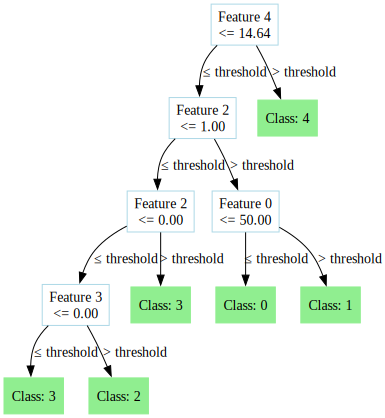

In [46]:
tree.visualize()

## **Report on Decision Tree**

A *decision tree* is a supervised learning algorithm used for classification and regression tasks.

#### **Overview**

Decision Tree Classifier consists of the following key components:

 - Node Class: Represents each node in the decision tree
 - DecisionTree Class: Implements the tree learning algorithm, including impurity calculation, best split selection, recursive tree construction, and prediction.

#### 1. **Core Functions**

**Gini Impurity Calculation `(gini(y))`**

function computes the Gini impurity to measure the dataset's purity using formula:
$$ Gini = 1 - \sum p_i^2 $$

where *p* is the proportion of class *i*.

#### 2. **Finding the Best Split `best_split(X, y)`**

This function iterates over all features and thresholds to find the best splitting point.

$$ Gini_{total} = \frac{|Left|}{|Total|} Gini_{Left} + \frac{|Right|}{|Total|} Gini_{Right} $$

#### 3. **Recursive Tree Building `build_tree(X, y)`**

The tree is built recursively by splitting the dataset.

This process continues until

 - a) All samples belong to the same class.
 - b) The maximum depth is reached.

#### 4. **Model Training `fit(X, y)`**

Function calls `build_tree(X, y)` to construct the decision tree from the training data *(X_train, y_train)*.

#### 5. **Prediction `predict(X)`**

For each input sample, the function traverses the tree, following decision nodes based on feature thresholds until reaching a leaf node.

### **Time Complexity**

- Finding the best split: **O(F × N log N)**, where **F** is the number of features and **N** is the number of samples.
- Building the tree: **O(N log N)**. This is not accurate formula, because the resulting time depends on dataset characteristics.
- Prediction: **O(log N)**.